<style>
th {background-color:#55FF33;}
td {background-color:#00FFFF;}
</style>

<img align="right" style="max-width: 200px; height: auto" src="01_images/hsg_logo.png">

### Lab 03 - "Mathematisch-Statistische Analyseverfahren"

ACA Lehrgang "Internal Audit Knowledge Elements", Universität St. Gallen, 15. Januar 2020

In diesem Lab werden wir Jupyter Notebook nutzen, um erste **mathematisch-statistische Analyseverfahren** im Kontext der revisorischen Datenanalyse zu implementieren und anzuwenden. Zielsetzung des Labs ist es, exemplarisch die Analyse der führenden Ziffern einer Grundgesamtheit an Finanztransaktionen nach Benford an einem konkreten Beispiel durchzuführen:

<img align="center" style="max-width: 800px; height: auto" src="01_images/benford.png">

Zögern Sie bitte nicht Fragen entweder unmittelbar während der Durchführung des Labs zu stellen oder uns im Nachgang eine E-Mail an marco.schreyer@unisg.ch zu senden.

### Lernziele des Labs:

Das vorliegende Lab sollte Ihnen ermöglichen:
    
> 1. zu verstehen wie sich unter Verwendung von **Jupyter** und **Python** statistische Datenanalysen durchführen lassen;
> 2. die **Pandas** Bibliothek zu verwenden um eine Vielfalt von Transaktionsdaten zielgerichtet zu analysieren;
> 3. die **Matplotlib** Bibliothek zu verwenden um eigene Datenvisualisierungen zu erstellen;
> 4. erste **konkretere Ideen** für mögliche Datenanalysen innerhalb Ihres Unternehmens bzw. Ihrer Institution zu entwickeln.

Aber bevor wir beginnen lassen Sie uns ein kurzes Motivationsvideo schauen:

In [1]:
from IPython.display import YouTubeVideo
# NVIDIA: "I AM AI"
# YouTubeVideo('Dy0hJWltsyE', width=1024, height=576)

### 0. Analyseumgebung

In Analogie zu unserem Einführungslab, ist es zunächst wieder notwendig einige Python-Bibliotheken zu importieren die uns die Datenakquise, Datenanalyse und Datenvisualisierung erlauben. Im Rahmen dieses Labs werden wir im Besonderen die beiden Bibliotheken (1) **Pandas** (https://pandas.pydata.org) im Rahmen der Datenanalyse und (2) **Matplotlib** (https://matplotlib.org) im Rahmen der Datenvisualiserung verwenden.

Importieren wir jedoch zu Beginn die für die Datenakquise benötigten Python Bibliotheken durch die Ausführung der nachfolgenden Anweisungen:

In [2]:
import io
import zipfile
import urllib

Importiere nun einige Python "Utilities" Bibliotheken:

In [3]:
import os # ermöglicht den Zugriff auf das lokale Dateisystem
import datetime as dt # ermöglicht die Erstellung von Zeitstempeln

Importiere die Python Datenanalyse (oder "Data Science") Bibliotheken:

In [4]:
import numpy as np
import pandas as pd

Importiere die Python Datenvisualiserungs Bibliothek und setze globale Parameter der Datenvisualisierung:

In [5]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi']= 150

Aktivieren das "Inline-Plotten" von Visualisierungen innerhalb des aktuellen Notebooks:

In [6]:
%matplotlib inline

Suppress potential warnings:

In [7]:
import warnings
warnings.filterwarnings('ignore')

Erstellung eines lokalen Unterordners mit Ordnerbezeichnung **"03_results"** für das Speichern der nachfolgend erzeugten Ergebnisdateien der durchgeführeten Analysen:

In [8]:
if not os.path.exists('./03_results'): os.makedirs('./03_results')

### 1. Datenimport

Der synthetische **PaySim** Datensatz simuliert mobile Geldtransaktionen auf der Basis realer Transaktionen, die aus einem Monat Finanzprotokolle eines in einem afrikanischen Land implementierten mobilen Finanzdienstleisters extrahiert wurden. Die ursprünglichen Protokolle wurden von einem multinationalen Unternehmen bereitgestellt, das der Anbieter der mobilen Finanzdienstleistungen ist. Zum Zeitpunkt der Veröffentlichung der Daten operierte der Dienstleister in mehr als 14 Ländern weltweit.

Insgesamt umfasst der **PaySim** Datensatz eine Grundgesamtheit von **6.3 Mio. protokollierten Transaktionen**. Jede Transaktion enthält **neun unterschiedliche Merkmale**. Die Merkmalsbezeichnungen sowie ihre jeweils semantische Bedeutung ist nachfolgend angeführt:

>- `Step:` Bezeichnet die aktuelle Zeitstunde. Insgesamt 744 Stunden (30 Simulationstage).
>- `Type:` Bezeichnet den Typ der Transaktion. Insgesamt 5 verschiedene Transaktionstypen.
>- `Amount:` Bezeichnet den transferierten Betrag in lokaler Währung.

>- `NameOrig:` Bezeichnet die (anonymisierte) ID des Senders, welcher die Transaktion in Auftrag gab.
>- `OldBalanceOrg:` Bezeichnet den initialen Kontostand des Senders vor der Transaktion.
>- `NewBalanceOrig:` Bezeichnet den neuen Kontostand des Senders nach erfolgter Transaktion.

>- `NameDest:` Bezeichnet die (anonymisierte) ID des Empfängers der Transaktion.
>- `OldBalanceOrg:` Bezeichnet den initialen Kontostand des Empfängers vor der Transaktion.
>- `NewBalanceOrig:` Bezeichnet den neuen Kontostand des Empfängers nach erfolgter Transaktion.

Darüber hinaus ist jede Transaktion mit den nachfolgenden **zwei zusätzlichen Kennzeichen** versehen:

>- `isFraud:` Kennzeichnet tatsächliche "fraudbehaftete" Transaktionen
>- `isFlaggedFraud:` Kennzeichnet durch das System erkannte "fraudbehaftete" Transaktionen.

Weitere Details des Datensatzes sowie der Datensatz selbst können über die nachfolgende Publikation *E. A. Lopez-Rojas , A. Elmir, and S. Axelsson. "PaySim: A financial mobile money simulator for fraud detection". In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus. 2016* bzw. die nachfolgende Webseite: https://www.kaggle.com/ntnu-testimon/paysim1 bezogen werden.

Lassen Sie uns nun einen Teilextrakt des zuvor beschriebenen Datensatzes bestehend aus **2.770.409 protokollierten Transaktionen** in das Notebook importieren. Hierzu definieren wir zunächst den Pfad bzw. die URL der zu importierenden Transaktionsdaten: 

In [9]:
# setzen der URL der zu beziehenden Transaktionsdaten
url = 'https://raw.githubusercontent.com/GitiHubi/courseACA/master/lab03/02_data/transactions.zip'

Aufruf der URL und Download des Zip-Archivs in das Notebook:

In [10]:
resp = urllib.request.urlopen(url)
datazip = zipfile.ZipFile(io.BytesIO(resp.read()))

Entpacken der geladenen Zipdatei und Einlesen als Comma-Seperated-Value (CSV) in die Pandas Bibliothek:

In [11]:
data = pd.read_csv(datazip.open('transactions.csv'))

Inspektion der ersten 10 im Datensatz enthaltenen Transaktionen (Zeilen):

In [12]:
data.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.0,0.00,1,0
1,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.0,0.00,1,0
2,1,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.0,51513.44,0,0
3,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.0,0.00,0,0
4,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.0,2719172.89,0,0
5,1,CASH_OUT,110414.71,C768216420,26845.41,0.0,C1509514333,288800.0,2415.16,0,0
6,1,CASH_OUT,56953.90,C1570470538,1942.02,0.0,C824009085,70253.0,64106.18,0,0
7,1,CASH_OUT,5346.89,C512549200,0.00,0.0,C248609774,652637.0,6453430.91,0,0
8,1,CASH_OUT,23261.30,C2072313080,20411.53,0.0,C2001112025,25742.0,0.00,0,0
9,1,TRANSFER,62610.80,C1976401987,79114.00,16503.2,C1937962514,517.0,8383.29,0,0


### 2. Datenvalidierung

Die **Datenvalidierung** ist ein entscheidendes Element im Vorfeld jeder revisorischen Datenanalyse. Sie schafft Vertrauen in die Vollständigkeit und Fehlerfreiheit der zu analysierenden Daten. Die **strukturelle** und **semantische** Datenvalidierung der zu analysierenden ist notwendig, um eventuelle Analysefehler zu mindern. Die fehlende initiale Validierung der zu analysierenden Daten birgt ein erhöhtes Risiko fehlerhafter Analysergebnisse und der daraus abgeleiteten Schlussfolgerungen und Entscheidungen.

#### 2.1. Vergabe eindeutiger Transaktionsschlüssel

Ein eindeutiger **Transaktionsschlüssel** dient innerhalb des Datenbestands dazu, einzelne Datensätze eindeutig zu markieren um diese im Rahmen des weiteren Analysevorgehens eindeutig zu identifizieren. Ein Schlüssel ist oftmals eine Sequenz von Werten, die so ausgewählt wird, dass jede Zeile im Datenbestand ein eindeutiges Merkmal zur Identifikation aufweist. 

Erzeugung einer eindeutigen Sequenz von Transaktionschlüsseln:

In [13]:
keys = list(range(0, data.shape[0]))

Verifikation der erzeugten Transaktionsschlüssel:

In [14]:
#keys

Vergabe eines eindeutigen Transaktionsschlüssels pro Transaktion:

In [15]:
data.insert(0, "AUDIT_ID", keys)

Verifizierung der eindeutigen Transaktionsschlüsselvergabe:

In [16]:
data.head(10)

,AUDIT_ID,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,0,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.0,0.00,1,0
1,1,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.0,0.00,1,0
2,2,1,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.0,51513.44,0,0
3,3,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.0,0.00,0,0
4,4,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.0,2719172.89,0,0
5,5,1,CASH_OUT,110414.71,C768216420,26845.41,0.0,C1509514333,288800.0,2415.16,0,0
6,6,1,CASH_OUT,56953.90,C1570470538,1942.02,0.0,C824009085,70253.0,64106.18,0,0
7,7,1,CASH_OUT,5346.89,C512549200,0.00,0.0,C248609774,652637.0,6453430.91,0,0
8,8,1,CASH_OUT,23261.30,C2072313080,20411.53,0.0,C2001112025,25742.0,0.00,0,0
9,9,1,TRANSFER,62610.80,C1976401987,79114.00,16503.2,C1937962514,517.0,8383.29,0,0


In [17]:
data.tail(10)

,AUDIT_ID,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2770399,2770399,742,TRANSFER,63416.99,C778071008,63416.99,0.0,C1812552860,0.00,0.00,1,0
2770400,2770400,742,CASH_OUT,63416.99,C994950684,63416.99,0.0,C1662241365,276433.18,339850.17,1,0
2770401,2770401,743,TRANSFER,1258818.82,C1531301470,1258818.82,0.0,C1470998563,0.00,0.00,1,0
2770402,2770402,743,CASH_OUT,1258818.82,C1436118706,1258818.82,0.0,C1240760502,503464.50,1762283.33,1,0
2770403,2770403,743,TRANSFER,339682.13,C2013999242,339682.13,0.0,C1850423904,0.00,0.00,1,0
2770404,2770404,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
2770405,2770405,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
2770406,2770406,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
2770407,2770407,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
2770408,2770408,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


#### 2.2. Strukturelle Datenvalidierung

Die **strukturelle Datenvalidierung** validiert, ob die erhaltenen Daten technische Inkonsistenzen ("Lücken") zwischen erwarteten Datengrundgesamtheit und der tatsächlich erhaltenen Datengrundgesamtheit aufweisen, z.B. fehlende Datensätze oder Formatierungsfehler. Zielsetzung ist hierbei primär die technische Vollständigkeit und Integrität der erhaltenen Daten sicher zu stellen.

Verifizierung der Vollständigkeit der erhaltenen Datensätze:

In [18]:
data.shape[0]

2770409

Verifizierung der Vollständigkeit der erhaltenen Datenfelder:

In [19]:
data.shape[1]

12

Verifizierung des Datentypes der erhaltenen Datenfelder:

In [20]:
data.dtypes

AUDIT_ID            int64
step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

#### 2.3. Semantische Datenvalidierung

Die **semantische Datenvalidierung** validiert, ob die erhaltenen Daten semantische Inkonsistenzen ("Unstimmigkeiten") zwischen erwarteten Datengrundgesamtheit und der tatsächlich erhaltenen Datengrundgesamtheit aufweisen, z.B. ungewöhnliche oder fehlerhafte Feldausprägungen. Zielsetzung ist hierbei primär die semantische Vollständigkeit und Konsistenz der erhaltenen Daten sicher zu stellen.

**Beispielhafte Verifizierung individueller Feldausprägungen der zu analysierenden Transaktionsdaten:**

Anzahl der verschiedenen Feldausprägungen pro Datenfeld der erhaltenen Transaktionsdaten:

In [21]:
data.nunique()

AUDIT_ID          2770409
step                  743
type                    2
amount            2685805
nameOrig          2768630
oldbalanceOrg      435702
newbalanceOrig     271977
nameDest           509565
oldbalanceDest    2360852
newbalanceDest    2562844
isFraud                 2
isFlaggedFraud          2
dtype: int64

Anzahl der verschiedenen Wertverteilungen pro Datenfeld der erhaltenen Transaktionsdaten:

In [22]:
data.describe()

,AUDIT_ID,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,2.770409e+06,2.770409e+06,2.770409e+06,2.770409e+06,2.770409e+06,2.770409e+06,2.770409e+06,2.770409e+06,2.770409e+06
mean,1.385204e+06,2.420081e+02,3.175361e+05,4.764308e+04,1.609190e+04,1.703551e+06,2.049734e+06,2.964544e-03,5.775321e-06
std,7.997483e+05,1.416191e+02,8.877897e+05,2.513251e+05,1.512558e+05,4.225550e+06,4.676990e+06,5.436687e-02,2.403183e-03
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.926020e+05,1.550000e+02,8.297354e+04,0.000000e+00,0.000000e+00,1.280734e+05,3.272891e+05,0.000000e+00,0.000000e+00
50%,1.385204e+06,2.360000e+02,1.712609e+05,3.039600e+02,0.000000e+00,5.557100e+05,8.280539e+05,0.000000e+00,0.000000e+00
75%,2.077806e+06,3.320000e+02,3.067912e+05,3.099700e+04,0.000000e+00,1.735900e+06,2.122198e+06,0.000000e+00,0.000000e+00
max,2.770408e+06,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


Anzahl der Feldausprägungen individueller Datenfelder der erhaltenen Transaktionsdaten:

In [23]:
# analyse der verteilung bzw. histograms
data["type"].value_counts()

CASH_OUT    2237500
TRANSFER     532909
Name: type, dtype: int64

Visualisierung der Feldausprägungen individueller Datenfelder der erhaltenen Transaktionsdaten:

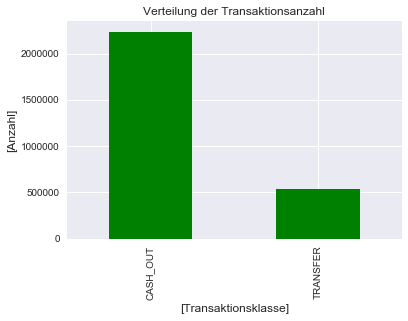

In [24]:
# initialisierung des Plots
fig, ax = plt.subplots()

# zeichnen des Histograms
data["type"].value_counts().plot(ax=ax, kind='bar', color="green")

# hinzufügen der Achsenbeschriftungen
plt.ylabel("[Anzahl]", fontsize=12)
plt.xlabel("[Transaktionsklasse]", fontsize=12)

# hinzufügen des Titels
plt.title("Verteilung der Transaktionsanzahl", fontsize=12);

**Beispielhafte Verifizierung kombinierter Feldausprägungen der zu analysierenden Transaktionsdaten:**

Anzahl der Feldausprägungen der kombinierten Datenfelder "Transaktionstyp" und "Fraudkennzeichen" der erhaltenen Transaktionsdaten:

In [25]:
data.groupby(["type", "isFraud"])["step"].count()

type      isFraud
CASH_OUT  0          2233384
          1             4116
TRANSFER  0           528812
          1             4097
Name: step, dtype: int64

Visualisierung der Feldausprägungen der kombinierten Datenfelder "Transaktionstyp" und "Fraudkennzeichen" der erhaltenen Transaktionsdaten:

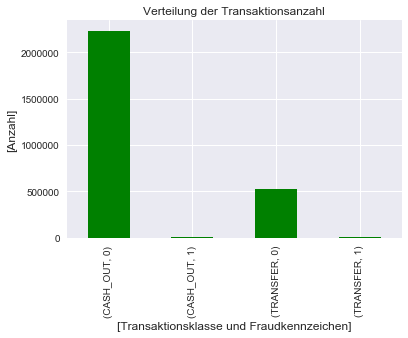

In [26]:
# initialisierung des Plots
fig, ax = plt.subplots()

# zeichnen des Histograms
data.groupby(["type", "isFraud"])["step"].count().plot(ax=ax, kind="bar", color="green")

# hinzufügen der Achsenbeschriftungen
plt.ylabel("[Anzahl]", fontsize=12)
plt.xlabel("[Transaktionsklasse und Fraudkennzeichen]", fontsize=12)

# hinzufügen des Titels
plt.title("Verteilung der Transaktionsanzahl", fontsize=12);

**Beispielhafte Verifizierung des zeitlichen Verlaufs der zu analysierenden Transaktionsdaten:**

Vollständige Extraktion der Transaktionen des Transaktionstyps "CASH_OUT":

In [27]:
# filtern der "cash-out" Transaktionen
transactions_cash_out = data[data["type"] == "CASH_OUT"]

Verifikation der Vollständigkeit der extrahierten Transaktionen des Transaktionstyps "CASH_OUT":

In [28]:
transactions_cash_out.shape[0]

2237500

Visualisierung des Transaktionsbetrags der "CASH_OUT" Transaktionen im Zeitverlauf:

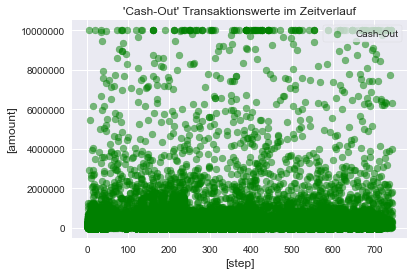

In [29]:
# initialisierung des Plots
fig, ax = plt.subplots()

# zeichnen des Scatterplots
plt.scatter(transactions_cash_out["step"], transactions_cash_out["amount"], color="green", alpha=0.5, label="Cash-Out")

# hinzufügen der Achsenbeschriftungen
plt.ylabel("[amount]", fontsize=12)
plt.xlabel("[step]", fontsize=12)

# formatierung der Achsenticklabel
ax.ticklabel_format(style='plain')

# hinzufügen der Legende
plt.legend(loc="upper right", frameon=True)

# hinzufügen des Titels
plt.title("'Cash-Out' Transaktionswerte im Zeitverlauf");

Vollständige Extraktion der Transaktionen des Transaktionstyps "TRANSFER":

In [30]:
# filtern der "transfer" transaktionen
transactions_transfer = data[data["type"] == "TRANSFER"]

Verifikation der Vollständigkeit der extrahierten Transaktionen des Transaktionstyps "TRANSFER":

In [31]:
transactions_transfer.shape[0]

532909

Visualisierung des Transaktionsbetrags der "TRANSFER" Transaktionen im Zeitverlauf:

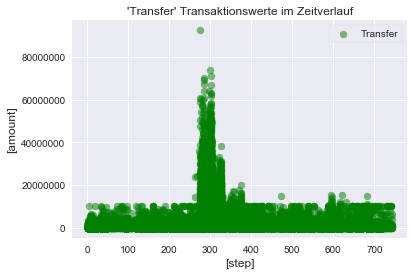

In [32]:
# initialisierung des Plots
fig, ax = plt.subplots()

# zeichnen des Scatterplots
plt.scatter(transactions_transfer["step"], transactions_transfer["amount"], color="green", alpha=0.5, label="Transfer")

# hinzufügen der Achsenbeschriftungen
plt.ylabel("[amount]", fontsize=12)
plt.xlabel("[step]", fontsize=12)

# formatierung der Achsenticklabel
ax.ticklabel_format(style='plain')

# hinzufügen der Legende
plt.legend(loc="upper right", frameon=True)

# hinzufügen des Titels
plt.title("'Transfer' Transaktionswerte im Zeitverlauf");

### 3. Datenaufbereitung

Unter **Datenaufbereitung** versteht man die Bereinigung und Transformation von Rohdaten vor der eigentlichen Verarbeitung und Analyse. Die Datenaufbereitung ist ein wichtiger Schritt vor der eigentlich durchzuführenden Datenanalyse und umfasst häufig das erneute Formatieren von Daten, die Berichtigung von Informationen und die Kombination von Datensätzen zur Anreicherung dieser Daten.

#### 3.1. Formattierung von Datenfeldern

Die Formattierung von Datenfeldern dient oftmals dazu die vorliegenden Daten in ein analysegeeignetes oder menschlich lesbares Format zu übertragen. Im Nachfolgenden möchten wir die beiden Datenfelder **"isFraud"** und **"isFlaggedFraud"** der "CASH_OUT" Transaktionen in ein menschlich lesbares Datenformat überführen:

In [33]:
transactions_cash_out.head(5)

,AUDIT_ID,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1,1,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.0,0.00,1,0
2,2,1,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.0,51513.44,0,0
5,5,1,CASH_OUT,110414.71,C768216420,26845.41,0.0,C1509514333,288800.0,2415.16,0,0
6,6,1,CASH_OUT,56953.90,C1570470538,1942.02,0.0,C824009085,70253.0,64106.18,0,0
7,7,1,CASH_OUT,5346.89,C512549200,0.00,0.0,C248609774,652637.0,6453430.91,0,0


Formattierung des Feldes "isFraud":

In [34]:
transactions_cash_out.loc[transactions_cash_out['isFraud'] == 1, 'isFraud'] = 'yes' # ersetzen des Wertes "1" durch "yes"
transactions_cash_out.loc[transactions_cash_out['isFraud'] == 0, 'isFraud'] = 'no' # ersetzen des Wertes "0" durch "no"

Stichprobenhafte Verifikation der Formattierung:

In [35]:
transactions_cash_out.head(5)

,AUDIT_ID,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1,1,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.0,0.00,yes,0
2,2,1,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.0,51513.44,no,0
5,5,1,CASH_OUT,110414.71,C768216420,26845.41,0.0,C1509514333,288800.0,2415.16,no,0
6,6,1,CASH_OUT,56953.90,C1570470538,1942.02,0.0,C824009085,70253.0,64106.18,no,0
7,7,1,CASH_OUT,5346.89,C512549200,0.00,0.0,C248609774,652637.0,6453430.91,no,0


Formattierung des Feldes "isFlaggedFraud":

In [36]:
transactions_cash_out.loc[transactions_cash_out['isFlaggedFraud'] == 1, 'isFlaggedFraud'] = 'yes' # ersetzen des Wertes "1" durch "yes"
transactions_cash_out.loc[transactions_cash_out['isFlaggedFraud'] == 0, 'isFlaggedFraud'] = 'no' # ersetzen des Wertes "0" durch "no"

Stichprobenhafte Verifikation der Formattierung:

In [37]:
transactions_cash_out.head(5)

,AUDIT_ID,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1,1,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.0,0.00,yes,no
2,2,1,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.0,51513.44,no,no
5,5,1,CASH_OUT,110414.71,C768216420,26845.41,0.0,C1509514333,288800.0,2415.16,no,no
6,6,1,CASH_OUT,56953.90,C1570470538,1942.02,0.0,C824009085,70253.0,64106.18,no,no
7,7,1,CASH_OUT,5346.89,C512549200,0.00,0.0,C248609774,652637.0,6453430.91,no,no


### 4. Mathematisch-Statistische Datenanalyse

<img align="center" style="max-width: 800px; height: auto" src="01_images/analytics.png">

#### 4.1. Benfordanalyse der führenden Ziffer des Transaktionsbetrags

<p>
    <table class="table table-bordered table-striped table-hover">
    <col width="150">
        <tr>
            <td><b>Risiko: </b></td>
            <td><p align="left">Ungewöhnliche hohe Zahlungsausgänge bergen ein erhöhtes Schadensrisiko.</p></td>
        </tr>
        <tr>
            <td><b>Daten: </b></td>
            <td><p align="left">Grundgesamtheit der 2'237'500 "Cash-Out" Transaktion des 'PaySim' Datensatzes.</p></td>
        </tr>
        <tr>
            <td><b>Analyse: </b></td>
            <td><p align="left">Identifikation aller "Cash-Out" Transaktionen die einen Transaktionsbetrag höher oder gleich 10 Mio. in lokaler Währung aufweisen. Extraktion der einschlägigen "Cash-Out" Transaktionen aus dem 'PaySim' Datensatz für eine stichprobenhafte Einzelfallprüfung.</p></td>
        </tr>
    </table>
</p>

Ermittlung der Benford Referenzverteilung der Auftrittswahrscheinlichkeit einer führenden Ziffer:

In [38]:
# erstellung der benford look-up tabelle für die Ziffern 1 bis 10
benford_table = pd.DataFrame({"ziffer_1": range(1, 10)})

# ermittlung der Benfordwahrscheinlichkeiten der unterschiedlichen Ziffern
benford_table["benford"] = (np.log10(benford_table["ziffer_1"] + 1)) - np.log10(benford_table["ziffer_1"])

Verfikation der ermittelten Auftrittswahrscheinlichkeiten pro Ziffer nach Benford:

In [39]:
benford_table

,ziffer_1,benford
0,1,0.301030
1,2,0.176091
2,3,0.124939
3,4,0.096910
4,5,0.079181
5,6,0.066947
6,7,0.057992
7,8,0.051153
8,9,0.045757


Ermittlung eines entsprechenden Konfidenzintervalls von drei Standdardbweichungen:

In [40]:
# ermittlung der Gesamtanzahl der "Cash-Out" Transaktionen
n = transactions_cash_out.shape[0]

# berechnung der oberen Schranke des Konfidenzintervalls
benford_table["benford_upp"] = benford_table["benford"] + 1.96 * np.sqrt((benford_table["benford"] * (1 - benford_table["benford"]))/n) 

# berechnung der unteren Schranke des Konfidenzintervalls
benford_table["benford_low"] = benford_table["benford"] - 1.96 * np.sqrt((benford_table["benford"] * (1 - benford_table["benford"]))/n) 

Verfikation der ermittelten Wahrscheinlichkeiten samt Konfidenzintervall:

In [41]:
benford_table

,ziffer_1,benford,benford_upp,benford_low
0,1,0.301030,0.301631,0.300429
1,2,0.176091,0.176590,0.175592
2,3,0.124939,0.125372,0.124505
3,4,0.096910,0.097298,0.096522
4,5,0.079181,0.079535,0.078827
5,6,0.066947,0.067274,0.066619
6,7,0.057992,0.058298,0.057686
7,8,0.051153,0.051441,0.050864
8,9,0.045757,0.046031,0.045484


Extraktion der führenden Ziffer aus den Transaktionsbeträgen der "CASH_OUT" Transaktionen:

In [42]:
transactions_cash_out["ziffer_1"] = transactions_cash_out["amount"].astype(str).str[0]

Verfikation der Ziffernextraktion:

In [43]:
transactions_cash_out[["amount", "ziffer_1"]].head(10)

,amount,ziffer_1
1,181.00,1
2,229133.94,2
5,110414.71,1
6,56953.90,5
7,5346.89,5
8,23261.30,2
10,82940.31,8
11,47458.86,4
12,136872.92,1
13,94253.33,9


Ermittlung der tatsächlichen Auftrittswahrscheinlichkeiten pro führender Ziffer innerhalb der "CASH_OUT" Transaktionen:

In [44]:
# erstellung der benford look-up tabelle für die Ziffern 1 bis 10 
# auf Grundlage der in den Transaktionsdaten enthaltenen Beträgen
benford_analysis = pd.DataFrame({"ziffer_1": transactions_cash_out["ziffer_1"].value_counts().index.astype(np.int64).tolist()})

# ermittlung der absoluten Auftrittswahrscheinlichkeit der führenden Ziffern der in den Transaktionsdaten enthaltenen Beträgen
benford_analysis["count"] = transactions_cash_out["ziffer_1"].value_counts().tolist()

# ermittlung der relativen Auftrittswahrscheinlichkeit der führenden Ziffern der in den Transaktionsdaten enthaltenen Beträgen
benford_analysis["probability"] = transactions_cash_out["ziffer_1"].value_counts(normalize=True).tolist()

Verfikation und Interpretration der Analyseergebnisse:

In [45]:
benford_analysis

,ziffer_1,count,probability
0,1,758707,0.339087
1,2,509358,0.227646
2,3,302973,0.135407
3,4,179977,0.080437
4,5,122878,0.054918
5,6,98713,0.044118
6,7,91125,0.040726
7,8,87516,0.039113
8,9,86234,0.038540
9,0,19,0.000008


Vergleich der Benford-Auftrittswahrscheinlichkeit und tatsächlichen Auftrittswahrscheinlichkeit:

In [46]:
analysis_result = benford_table.merge(benford_analysis, on="ziffer_1")

Vergleich beider Auftrittswahrscheinlichkeiten:

In [47]:
analysis_result

,ziffer_1,benford,benford_upp,benford_low,count,probability
0,1,0.301030,0.301631,0.300429,758707,0.339087
1,2,0.176091,0.176590,0.175592,509358,0.227646
2,3,0.124939,0.125372,0.124505,302973,0.135407
3,4,0.096910,0.097298,0.096522,179977,0.080437
4,5,0.079181,0.079535,0.078827,122878,0.054918
5,6,0.066947,0.067274,0.066619,98713,0.044118
6,7,0.057992,0.058298,0.057686,91125,0.040726
7,8,0.051153,0.051441,0.050864,87516,0.039113
8,9,0.045757,0.046031,0.045484,86234,0.038540


Visualisierung der Analyseergebnisse:

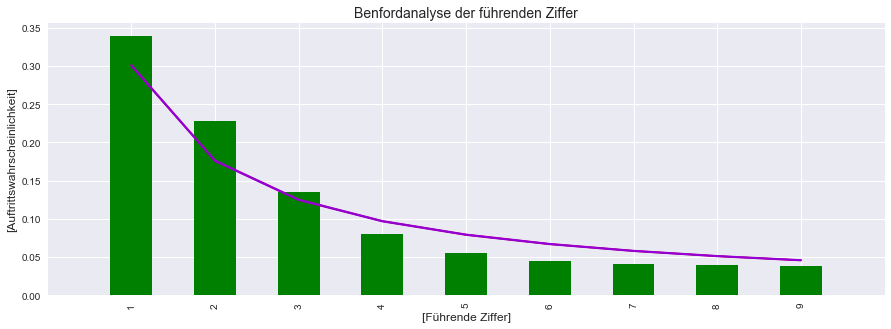

In [48]:
# initialisierung des Plots
fig, ax = plt.subplots(figsize=(15, 5))

# visualisierung der Ziffernverteilung nach Benford
analysis_result["benford"].plot(color="red")

# visualisierung des Konfidenzintervalls der Ziffernverteilung nach Benford
analysis_result["benford_upp"].plot(color="darkviolet") 
analysis_result["benford_low"].plot(color="darkviolet") 

# visualisierung der tatsächlichen Ziffernverteilung
analysis_result["probability"].plot(kind="bar", color="green")

# hinzufügen der Achsenbeschriftung
plt.ylabel("[Auftrittswahrscheinlichkeit]", fontsize=12)
plt.xlabel("[Führende Ziffer]", fontsize=12)

# formattierung der x-Achsen tick labels
plt.xticks(range(0,10), range(1,10))

# formattierung des x-Achsen Werte-Intervalls
plt.xlim([-1.0, 9.0])

# hinzufügen des Titels
plt.title("Benfordanalyse der führenden Ziffer", fontsize=14);

#### 4.2. Benfordanalyse der beiden führenden Ziffern des Transaktionsbetrags

Ermittlung der Benford Referenzverteilung der Auftrittswahrscheinlichkeit zweier führenden Ziffern:

In [49]:
# erstellung der benford look-up tabelle für die Ziffern 1 bis 100
benford_table = pd.DataFrame({"ziffer_2": range(1, 100)})

# ermittlung der Benfordwahrscheinlichkeiten der unterschiedlichen Ziffern
benford_table["benford"] = (np.log10(benford_table["ziffer_2"] + 1)) - np.log10(benford_table["ziffer_2"])

Verfikation der ermittelten Auftrittswahrscheinlichkeiten pro Zifferkombination nach Benford:

In [50]:
benford_table.head(20)

,ziffer_2,benford
0,1,0.301030
1,2,0.176091
2,3,0.124939
3,4,0.096910
4,5,0.079181
5,6,0.066947
6,7,0.057992
7,8,0.051153
8,9,0.045757
9,10,0.041393


Ermittlung eines entsprechenden Konfidenzintervalls von drei Standdardbweichungen:

In [51]:
# ermittlung der Gesamtanzahl der "Cash-Out" Transaktionen
n = transactions_cash_out.shape[0]

# berechnung der oberen Schranke des Konfidenzintervalls
benford_table["benford_upp"] = benford_table["benford"] + 1.96 * np.sqrt((benford_table["benford"] * (1 - benford_table["benford"]))/n) 

# berechnung der unteren Schranke des Konfidenzintervalls
benford_table["benford_low"] = benford_table["benford"] - 1.96 * np.sqrt((benford_table["benford"] * (1 - benford_table["benford"]))/n) 

Verfikation der ermittelten Wahrscheinlichkeiten samt Konfidenzintervall:

In [52]:
benford_table.head(20)

,ziffer_2,benford,benford_upp,benford_low
0,1,0.301030,0.301631,0.300429
1,2,0.176091,0.176590,0.175592
2,3,0.124939,0.125372,0.124505
3,4,0.096910,0.097298,0.096522
4,5,0.079181,0.079535,0.078827
5,6,0.066947,0.067274,0.066619
6,7,0.057992,0.058298,0.057686
7,8,0.051153,0.051441,0.050864
8,9,0.045757,0.046031,0.045484
9,10,0.041393,0.041654,0.041132


Extraktion der beiden führenden Ziffer aus den Transaktionsbeträgen der "CASH_OUT" Transaktionen:

In [53]:
transactions_cash_out["ziffer_2"] = transactions_cash_out["amount"].astype(str).str[0] + transactions_cash_out["amount"].astype(str).str[1]

Verifikation der Ziffernextraktion:

In [54]:
transactions_cash_out[["amount", "ziffer_2"]].head(10)

,amount,ziffer_2
1,181.00,18
2,229133.94,22
5,110414.71,11
6,56953.90,56
7,5346.89,53
8,23261.30,23
10,82940.31,82
11,47458.86,47
12,136872.92,13
13,94253.33,94


Ermittlung der tatsächlichen Auftrittswahrscheinlichkeiten pro führender Ziffernkombination innerhalb der "CASH_OUT" Transaktionen:

In [55]:
# erstellung der benford look-up tabelle für die Ziffern 1 bis 100
# auf Grundlage der in den Transaktionsdaten enthaltenen Beträgen
benford_analysis = pd.DataFrame({"ziffer_2": transactions_cash_out["ziffer_2"].value_counts().index.map(lambda t: t.replace('.', '')).astype(np.int64).tolist()})

# ermittlung der absoluten Auftrittswahrscheinlichkeit der führenden Ziffern der in den Transaktionsdaten enthaltenen Beträgen
benford_analysis["count"] = transactions_cash_out["ziffer_2"].value_counts().tolist()

# ermittlung der relativen Auftrittswahrscheinlichkeit der führenden Ziffern der in den Transaktionsdaten enthaltenen Beträgen
benford_analysis["probability"] = transactions_cash_out["ziffer_2"].value_counts(normalize=True).tolist()

Verfikation und Interpretration der Analyseergebnisse:

In [56]:
benford_analysis.head(20)

,ziffer_2,count,probability
0,10,84894,0.037941
1,11,82693,0.036958
2,12,81635,0.036485
3,13,79755,0.035645
4,14,77565,0.034666
5,15,75713,0.033838
6,16,73114,0.032677
7,17,70508,0.031512
8,18,67837,0.030318
9,19,64984,0.029043


Vergleich der Benford-Auftrittswahrscheinlichkeit und tatsächlichen Auftrittswahrscheinlichkeit:

In [57]:
analysis_result = benford_table.merge(benford_analysis, on="ziffer_2")

Ermittlung des Delta's zwischen der mittleren Benford- und tatsächlichen Auftrittswahrscheinlichkeit:

In [58]:
analysis_result["delta"] = np.abs(analysis_result["benford"] -  analysis_result["probability"])

Vergleich beider Auftrittswahrscheinlichkeiten:

In [59]:
analysis_result

,ziffer_2,benford,benford_upp,benford_low,count,probability,delta
0,1,0.301030,0.301631,0.300429,9,0.000004,0.301026
1,2,0.176091,0.176590,0.175592,12,0.000005,0.176086
2,3,0.124939,0.125372,0.124505,4,0.000002,0.124937
3,4,0.096910,0.097298,0.096522,5,0.000002,0.096908
4,5,0.079181,0.079535,0.078827,6,0.000003,0.079179
5,6,0.066947,0.067274,0.066619,8,0.000004,0.066943
6,7,0.057992,0.058298,0.057686,8,0.000004,0.057988
7,8,0.051153,0.051441,0.050864,5,0.000002,0.051150
8,9,0.045757,0.046031,0.045484,6,0.000003,0.045755
9,10,0.041393,0.041654,0.041132,84894,0.037941,0.003451


Visualisierung der Analyseergebnisse:

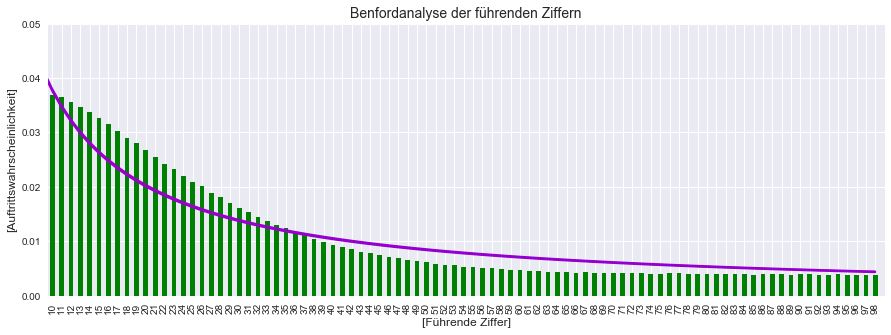

In [60]:
# initialisierung des Plots
fig, ax = plt.subplots(figsize=(15, 5))

# visualisierung der Ziffernverteilung nach Benford
analysis_result["benford"].plot(color="red")

# visualisierung des Konfidenzintervalls der Ziffernverteilung nach Benford
analysis_result["benford_upp"].plot(color="darkviolet") 
analysis_result["benford_low"].plot(color="darkviolet") 

# visualisierung der tatsächlichen Ziffernverteilung
analysis_result["probability"].plot(kind="bar", color="green")

# hinzufügen der Achsenbeschriftung
plt.ylabel("[Auftrittswahrscheinlichkeit]", fontsize=12)
plt.xlabel("[Führende Ziffer]", fontsize=12)

# formattierung der x-Achsen tick labels
#plt.xticks(range(9.5,10), range(1,10))

# formattierung des x-Achsen Werte-Intervalls
plt.xlim([9.5, 99.0])

# formattierung des y-Achsen Werte-Intervalls
plt.ylim([0.0, 0.05])

# hinzufügen des Titels
plt.title("Benfordanalyse der führenden Ziffern", fontsize=14);

#### 4.3. Detailanalyse der ausgewählten Ziffernkombination '14'

Auswahl der zu analysierenden Ziffernkombination:

In [61]:
digit = "14"

Filtern der "CASH-OUT" Transaktionen nach ausgewählter Ziffernkombination:

In [62]:
transactions_cash_out_14 = transactions_cash_out[transactions_cash_out["ziffer_2"] == digit]

Verfikation der Filterergebnisse:

In [63]:
transactions_cash_out_14.head(10)

,AUDIT_ID,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,ziffer_1,ziffer_2
37,37,1,CASH_OUT,14121.82,C69062746,0.00,0.00,C100555887,52679.00,10963.66,no,no,1,14
180,180,1,CASH_OUT,147804.02,C1086849943,66.14,0.00,C1182461167,158919.00,23508.22,no,no,1,14
181,181,1,CASH_OUT,145944.67,C177104018,24376.00,0.00,C1123629720,222.00,46393.85,no,no,1,14
252,252,1,CASH_OUT,144964.23,C1380976928,0.00,0.00,C932583850,785172.07,2719172.89,no,no,1,14
266,266,1,CASH_OUT,141111.15,C40875560,0.00,0.00,C2083562754,622023.34,1186556.81,no,no,1,14
307,307,1,CASH_OUT,142282.63,C1533547487,0.00,0.00,C453211571,805331.66,3461666.05,no,no,1,14
539,539,1,CASH_OUT,14750.26,C1098568947,21989.58,7239.33,C1899073220,1096233.87,420946.86,no,no,1,14
547,547,1,CASH_OUT,141648.13,C244577237,0.00,0.00,C1060830840,413572.32,130747.56,no,no,1,14
552,552,1,CASH_OUT,146534.96,C333879495,21114.00,0.00,C1112414583,0.00,67762.92,no,no,1,14
559,559,1,CASH_OUT,144659.77,C1936375962,149735.97,149735.97,C757108857,149735.97,0.00,no,no,1,14


Visualisierung der Transaktionsbeträge aller "CASH-OUT" Transaktionen mit führender Ziffern '14':

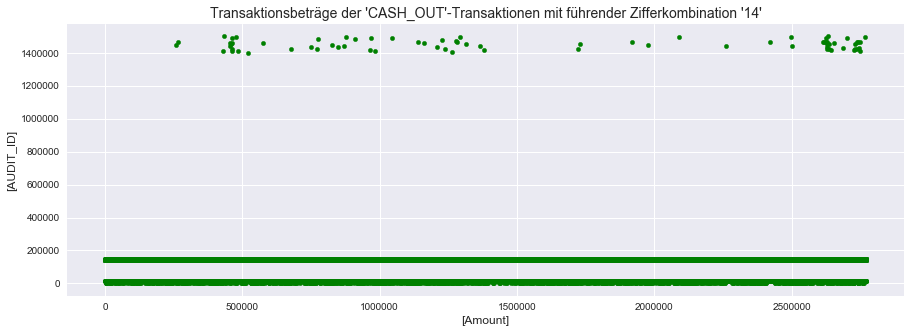

In [64]:
# initialisierung des Plots
fig, ax = plt.subplots(figsize=(15, 5))

# visualisierung der Betragsverteilung aller CASH-OUT Transaktionen mit führender Ziffer '14'
transactions_cash_out_14.plot(ax=ax, kind="scatter", x="AUDIT_ID", y="amount", color="green")

# hinzufügen der Achsenbeschriftung
plt.ylabel("[AUDIT_ID]", fontsize=12)
plt.xlabel("[Amount]", fontsize=12)

# hinzufügen des Titels
plt.title("Transaktionsbeträge der 'CASH_OUT'-Transaktionen mit führender Zifferkombination '14'", fontsize=14);

Extraktion der "CASH_OUT" Transaktionen deren Betrag die führende Ziffernkombination '14' aufweist und größer als 1.2 Mio ist:

In [65]:
# setzen des Transaktionsbetrag Schwellwertes
threshold = 1200000

# filtern nach auffälligen Beträgen > 1'200'000
transactions_cash_out_14_large = transactions_cash_out_14[(transactions_cash_out_14["ziffer_2"] == digit) & (transactions_cash_out_14["amount"] >= threshold)]

Stichprobenhafte Verifikation der Analyseergebnisse:

In [66]:
transactions_cash_out_14_large.head(20)

,AUDIT_ID,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,ziffer_1,ziffer_2
257738,257738,33,CASH_OUT,1448630.38,C942063884,1448630.38,0.0,C1317594509,1294571.45,2743201.82,yes,no,1,14
266688,266688,34,CASH_OUT,1462355.44,C1049482889,1462355.44,0.0,C373339841,1544724.84,3007080.29,yes,no,1,14
427983,427983,44,CASH_OUT,1412084.71,C1356165627,0.00,0.0,C1522224176,2821737.69,4233822.39,no,no,1,14
434976,434976,44,CASH_OUT,1499783.36,C26852894,0.00,0.0,C1517804467,1818662.64,3318446.00,no,no,1,14
454527,454527,85,CASH_OUT,1440705.58,C1733056191,1440705.58,0.0,C1061971573,0.00,1440705.58,yes,no,1,14
454593,454593,92,CASH_OUT,1461930.03,C1928781788,1461930.03,0.0,C1636281428,3762496.73,5224426.76,yes,no,1,14
457808,457808,94,CASH_OUT,1454592.61,C824268591,1454592.61,0.0,C819390198,264042.92,1718635.53,yes,no,1,14
463309,463309,100,CASH_OUT,1422963.14,C1871604900,1422963.14,0.0,C45991423,0.00,1422963.14,yes,no,1,14
463357,463357,105,CASH_OUT,1457085.28,C208508333,1457085.28,0.0,C1196762236,0.00,1457085.28,yes,no,1,14
463375,463375,106,CASH_OUT,1409248.64,C1173095546,1409248.64,0.0,C1935607545,914125.46,2323374.10,yes,no,1,14


Erzeugung eines Analysezeitstempels:

In [67]:
timestamp = dt.datetime.utcnow().strftime("%Y-%m-%d_%H-%M-%S")

Festlegung des Dateinamens der zu speichernden Analyseergebnisse:

In [68]:
filename = "C001_" + str(timestamp) + "_analysis_result_digits_14.csv"

Festlegung des Verzeichnises der zu speichernden Analyseergebnisse:

In [69]:
directory = os.path.join(os.getcwd(), '03_results', filename)

Speichern der Analyseergebnisse auf dem lokalen Dateisystem:

In [70]:
transactions_cash_out_14_large.to_csv(directory, sep=",", header=True, index=False, encoding="utf-8")

### Übungen:

Wir empfehlen die Durchführung der nachfolgenden Übungen im Rahmen das Labs:

**1. Analysieren Sie die "CASH-OUT" Transaktionen, welche die führenden Ziffernkombination 15 und 16 aufweisen.**

> Analysieren Sie die im Rahmen der Datenvalidierung extrahierten 2.2 Mio. "CASH-OUT" Transaktionen im Hinblick auf die führenden Ziffernkombinationen '15' und '16'. Orientieren Sie sich hierbei bitte an der unter Kapitel 4.3. des Notebooks vorgestellten Vorgehensweise. Extrahieren Sie Ihre Analyseergebnisse in gesonderte CSV-Datei für die ggf. nachgelagerte Einzelfallprüfung.

In [71]:
# ***************************************************
# Bitte geben Sie Ihre Lösung in dieses Feld ein
# ***************************************************

**2. Analysieren Sie die führenden Ziffernkombinationen der "TRANSFER" Transaktionen nach Benford.**

> Analysieren Sie die Transaktionsbeträge im Rahmen der Datenvalidierung extrahierten 532'909 "TRANSFER" Transaktionen nach Benford. Orientieren Sie sich hierbei bitte an der unter Kapitel 4.1. des Notebooks vorgestellten Vorgehensweise. Extrahieren Sie die Einzeltransaktionen der durch Sie ermittelten Auffälligkeiten in einer gesonderten CSV-Datei für die ggf. nachgelagerte Einzelfallprüfung.

In [72]:
# ***************************************************
# Bitte geben Sie Ihre Lösung in dieses Feld ein
# ***************************************************

### Zusammenfassung:

In diesem Lab wurde eine schrittweise Einführung in die mathematisch-statistische revisorische Datenanalyse vorgestellt. Hierbei wurden im Besonderen die Analyse der führenden Ziffern einer Grundgesamtheit an Finanztransaktionen nach Benford behandelt. Das in diesem Lab präsentierte Analysevorgehen kann einen Ausgangspunkt für komplexere und maßgeschneiderte Analysen darstellen.